In [1]:
import backtrader as bt 
import backtrader.analyzers as btanalyzers
import pandas as pd
import yfinance as yf
import matplotlib
from datetime import datetime

In [2]:
#### Download Daily and Hourly Data
btc_daily = yf.download('BTC', start='2021-01-01')


[*********************100%%**********************]  1 of 1 completed


In [3]:

btc_daily 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,100.122902,100.122902,100.122902,100.122902,95.819778,2
2021-01-05,100.059998,100.079903,100.050003,100.050003,95.750008,751
2021-01-06,99.859001,99.874603,99.859001,99.874603,95.582161,109
2021-01-07,99.830002,99.830002,99.785004,99.813698,95.523865,2099
2021-01-08,99.724998,99.724998,99.724998,99.724998,95.438980,3
...,...,...,...,...,...,...
2024-03-22,92.239601,92.239601,92.239601,92.239601,91.680511,120
2024-03-25,92.143303,92.143303,92.143303,92.143303,91.584793,13
2024-03-26,91.624001,91.624001,91.624001,91.624001,91.624001,93


In [4]:
btc_daily.to_csv('BTC_Daily.csv')

In [5]:
btc_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814 entries, 2021-01-04 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       814 non-null    float64
 1   High       814 non-null    float64
 2   Low        814 non-null    float64
 3   Close      814 non-null    float64
 4   Adj Close  814 non-null    float64
 5   Volume     814 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 44.5 KB


In [6]:
## Pass Data for Backtester to use it as source
btc_daily_parsed = bt.feeds.PandasData(dataname= btc_daily, 
                                    datetime = None, 
                                    open = 1, 
                                    high = 2, 
                                    low = 3, 
                                    close=4, 
                                    volume=5, 
                                    openinterest=-1)
                                    #timefrmae  = bt.TimeFrame.Minutes)
                                    

In [7]:


### GET DATA DIRECLTY FROM EXCHANGE
### GET DATA FROM MY FILE AND CONVERTED TO THE STRUCTURE

btc_daily = pd.read_csv('BTC_USDT_BYBIT_daily.csv')
#### Lets organise the data so Date time is data and also index

btc_daily['DateTime'] = pd.to_datetime(btc_daily['DateTime'])
btc_daily.set_index('DateTime', inplace=True, drop=True)

### we are going to parse this data into cerebro
##### we need to specifi what timeframe this correspons to  
#### I AM NOT GOIN TO USE THE timeframe thing, not sure how it works ??
btc_daily_parsed = bt.feeds.PandasData(dataname= btc_daily, 
                                    datetime = None, 
                                    open = 1, 
                                    high = 2, 
                                    low = 3, 
                                    close=4, 
                                    volume=5, 
                                    openinterest=-1)

In [10]:
###ADDING DATA TO CEREBRO
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)

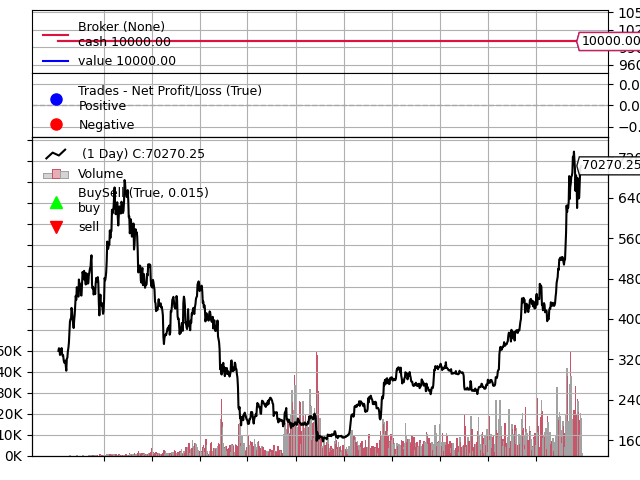

[[<Figure size 1536x1152 with 4 Axes>]]

In [11]:
cerebro.run()
%matplotlib widget
cerebro.plot(iplot=False)

In [12]:
### Strategy in where we buy when the 8 simple moving average crosses the 30 daily moving average


class MaCrossStrategy(bt.Strategy):
 
    params = (
        ('fast_length', 8),
        ('slow_length', 30), 
        
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        
 
    def next(self):
        if not self.position:
            if self.crossover > 0 : 
                self.buy()
        if self.position:
            if self.crossover < 0: 
                self.close()

In [13]:
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)
cerebro.addstrategy(MaCrossStrategy, fast_length = 8, slow_length = 30)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
 
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")

In [14]:
back = cerebro.run()

In [15]:
cerebro.broker.getvalue()

21937.960761278

In [16]:
back[0].analyzers.sharpe.get_analysis()['sharperatio']
 

0.6720320123081185

In [17]:

back[0].analyzers.returns.get_analysis()['rtot'] *100

78.5633411374571

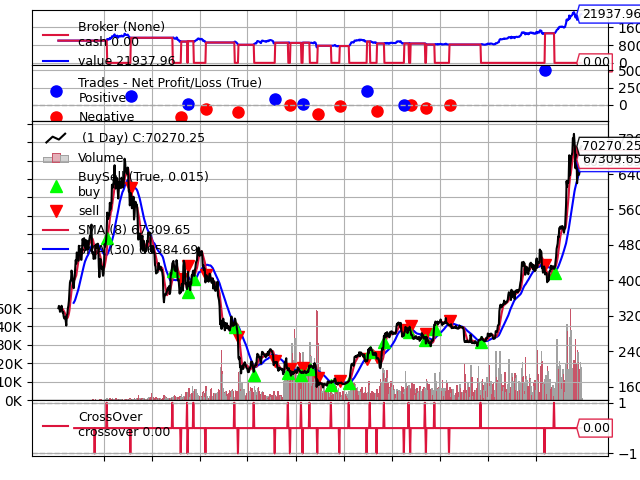

[[<Figure size 1536x1152 with 5 Axes>]]

In [18]:
cerebro.run()
%matplotlib widget
cerebro.plot(iplot=False)

## CREATE A DIFFERENT STRATEGY OR CHANGE SOME PARAMETERS TO OPTIMISE / ANALISSE DIFFERENT OPTIONS

In [19]:
### Here we will buy the asset when we have a Crossover of the 8 sma with the 30 SMA and we sell the asset when the price drops below the 3 Moving Average

class MaCrossStrategy_optimised(bt.Strategy):
 
    params = (
        ('fast_length', 8),
        ('slow_length', 30), 
        
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
        self.data_close = self.datas[0].close
        self.sma3 = bt.ind.SMA(self.data_close, period=3)
        
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        self.price_cross_3 = bt.ind.CrossOver(self.data_close, self.sma3)
        
 
    def next(self):
        if not self.position:
            if self.crossover: 
                self.buy()
        
        if self.position:
            if self.price_cross_3 < 0: 
                self.close()

In [20]:
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)
cerebro.addstrategy(MaCrossStrategy_optimised, fast_length = 8, slow_length = 30)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
 
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")

In [21]:
back = cerebro.run()
back[0].analyzers.sharpe.get_analysis()['sharperatio']

cerebro.broker.getvalue()

10927.05173112806

In [22]:
back[0].analyzers.sharpe.get_analysis()['sharperatio']

0.16609896405830157

In [23]:
back[0].analyzers.returns.get_analysis()['rtot'] * 100

8.865643183137104

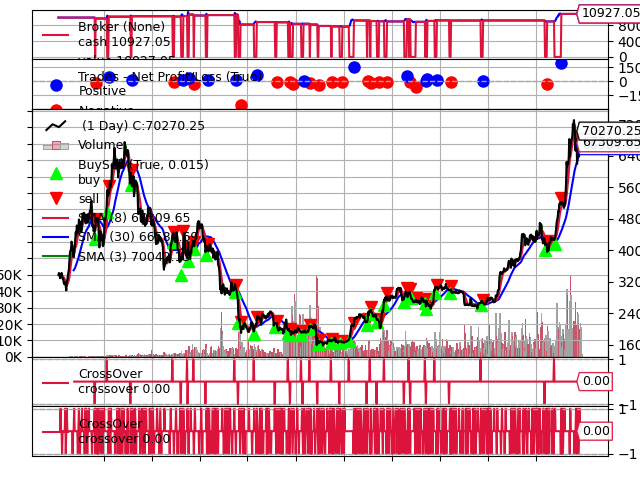

[[<Figure size 1536x1152 with 6 Axes>]]

In [24]:
cerebro.run()
%matplotlib widget
cerebro.plot(iplot=False)

## CREATE A DIFFERENT STRATEGY OR CHANGE SOME PARAMETERS TO OPTIMISE / ANALISSE DIFFERENT OPTIONS
We can keep changing parameters in order to see if our new hypothesis is better or worse

In [25]:
##### HOW WE CAN IMPROVE THIS ###
### Idea: Buy whne the proce Closes above the 30 DAY Moving Average and sell when the Price closes bewlo 3 Day Moving Average

class MaCrossStrategy_optimised_2(bt.Strategy):
 
    params = (
        ('fast_length', 8),
        ('slow_length', 30), 
        
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
        self.data_close = self.datas[0].close
        self.sma3 = bt.ind.SMA(self.data_close, period=3)
        self.sma30 = bt.ind.SMA(self.data_close, period=30)
        
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        
 
    def next(self):
        if not self.position:
            if self.data_close > self.sma30: 
                self.buy()
        
        if self.position:
            if self.data_close < self.sma3: 
                self.close()

In [26]:
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)
cerebro.addstrategy(MaCrossStrategy_optimised_2)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
 
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")

In [27]:
back = cerebro.run()

cerebro.broker.getvalue()

18927.414278441818

In [28]:
back[0].analyzers.sharpe.get_analysis()['sharperatio']

0.7116685277499194

In [29]:
back[0].analyzers.returns.get_analysis()['rtot'] * 100

63.80262690485754

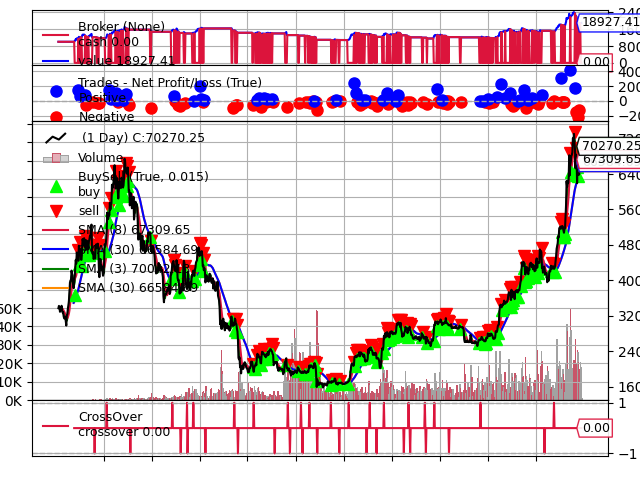

[[<Figure size 1536x1152 with 5 Axes>]]

In [30]:
%matplotlib widget
cerebro.plot(iplot=False)

## CREATE A DIFFERENT STRATEGY OR CHANGE SOME PARAMETERS TO OPTIMISE / ANALISSE DIFFERENT OPTIONS
We can keep changing parameters in order to see if our new hypothesis is better or worse

In [32]:
##### ONLY WHEN TRENDING ###
### Idea: Inlcuding some tranding Conditions
## How we know we are trending? Whne the 24 MOving Average is avobe the 30 Day Moving Average

class MaTREND(bt.Strategy):
 
    params = (
        ('fast_length', 24),
        ('slow_length', 30), 
        
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
        self.data_close = self.datas[0].close
        self.sma3 = bt.ind.SMA(self.data_close, period=3)
        self.sma8 = bt.ind.SMA(self.data_close, period=8)
        self.sma24 = bt.ind.SMA(self.data_close, period=24)
        self.sma30 = bt.ind.SMA(self.data_close, period=30)
        
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        self.price_cross_24 = bt.ind.CrossOver(self.data_close, self.sma24)
        self.price_cross_8 = bt.ind.CrossOver(self.data_close, self.sma8)
        self.price_cross_3 = bt.ind.CrossOver(self.data_close, self.sma3)
        
 
    def next(self):
        if not self.position:
            if self.price_cross_24 > 0 and (self.sma24 > self.sma30): 
                self.buy()
        
        if self.position:
            if self.price_cross_3 < 0:
             
                self.close()
            

In [33]:
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)
cerebro.addstrategy(MaTREND)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
 
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")

In [34]:
back = cerebro.run()

cerebro.broker.getvalue()

9500.502640621347

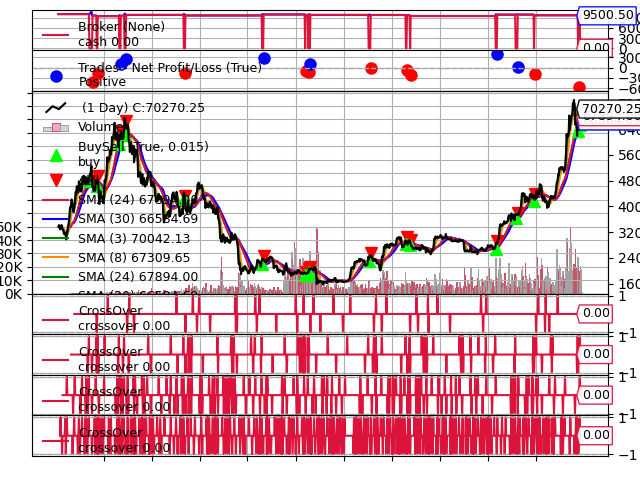

[[<Figure size 1536x1152 with 8 Axes>]]

In [35]:
%matplotlib widget
cerebro.plot(iplot=False)

## CREATE A DIFFERENT STRATEGY OR CHANGE SOME PARAMETERS TO OPTIMISE / ANALISSE DIFFERENT OPTIONS
We can keep changing parameters in order to see if our new hypothesis is better or worse

In [36]:
#### ONLY WHEN TRENDING ###
### Othe way to detec Trending

class SimpleTREND(bt.Strategy):
 
    params = (
        ('fast_length', 24),
        ('slow_length', 30), 
        
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
        self.data_close = self.datas[0].close
        self.sma3 = bt.ind.SMA(self.data_close, period=3)
        self.sma8 = bt.ind.SMA(self.data_close, period=8)
        self.sma24 = bt.ind.SMA(self.data_close, period=24)
        self.sma30 = bt.ind.SMA(self.data_close, period=30)
        
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        self.price_cross_24 = bt.ind.CrossOver(self.data_close, self.sma24)
        self.price_cross_8 = bt.ind.CrossOver(self.data_close, self.sma8)
        self.price_cross_3 = bt.ind.CrossOver(self.data_close, self.sma3)
        
 
    def next(self):
        if not self.position:
            if self.price_cross_8 > 0 and (self.sma24 > self.sma30) and (self.sma24 > self.sma3): 
                self.buy()
        
        if self.position:
            if self.price_cross_3 < 0:
             
                self.close()
                
            

In [37]:
cerebro = bt.Cerebro()
cerebro.adddata(btc_daily_parsed)
cerebro.addstrategy(SimpleTREND)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 100)
 
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(btanalyzers.Returns,     _name = "returns")

In [38]:
back = cerebro.run()

cerebro.broker.getvalue()

10803.718147927095

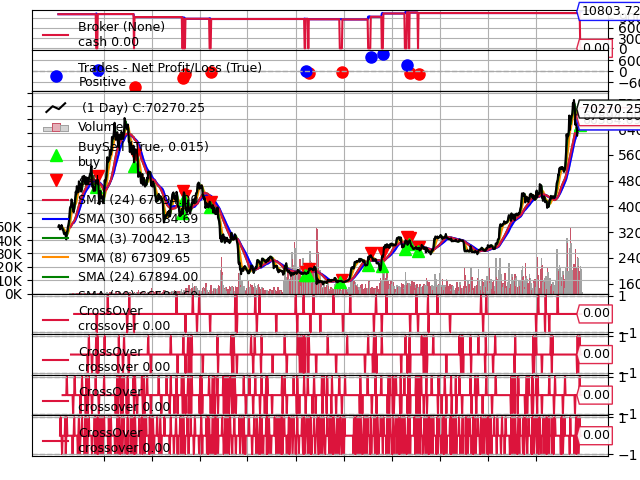

[[<Figure size 1536x1152 with 8 Axes>]]

In [39]:
%matplotlib widget
cerebro.plot(iplot=False)